# Panorama stitching, video stabilization and object tracking
## Made by: Ran Ben Melech


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
print(cv2.__version__)

plt.rc('image', cmap='gray') # set the default color-map of plt.image() to 'gray'
plt.rc('figure', figsize=[10,10]) # set a bigger default figure size

4.4.0


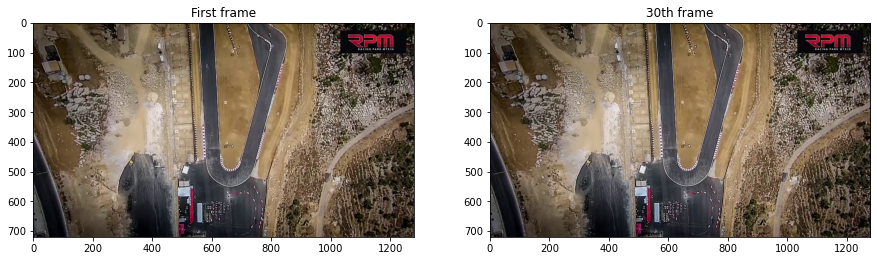

In [10]:
cap = cv2.VideoCapture('P3_racing.mov')

_,img1=cap.read()
for i in range(30):
    _,img2=cap.read()

img1toShow=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2toShow=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
panorama=cv2.imread('P3_map.jpg')
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img1toShow)
plt.title('First frame')
cap.release()
plt.subplot(1,2,2)
plt.imshow(img2toShow)
plt.title('30th frame')
plt.show()
cap.release()



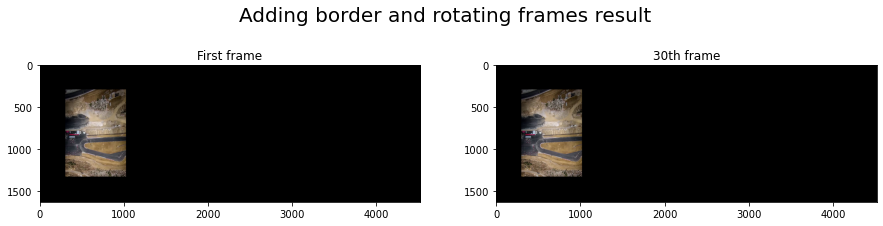

True

In [11]:
def addBorder(img):
    N=300
    M=3500
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) 
    img = img[:1030,:] # cutting the image so it won't have the water mark
    h1,w1 = img.shape[:2]
    res = cv2.copyMakeBorder(img.copy(), N, N, N, M, cv2.BORDER_CONSTANT)

    return(res)
b_img1=addBorder(img1)
b_img2=addBorder(img2)
img1toShow1=cv2.cvtColor(b_img1, cv2.COLOR_BGR2RGB)
img2toShow1=cv2.cvtColor(b_img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.suptitle("Adding border and rotating frames result",fontsize=20)
plt.subplot(1,2,1)
plt.imshow(img1toShow1)
#plt.savefig(img1toShow1)
plt.title('First frame')

plt.subplot(1,2,2)
plt.imshow(img2toShow1)
plt.title('30th frame')
plt.subplots_adjust(top=1.60)
plt.show()
cv2.imwrite('first.png', b_img1)

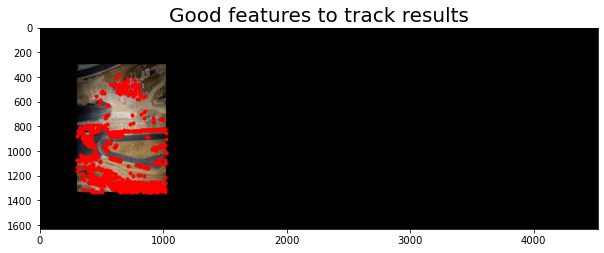

In [12]:
def getPoints(img):
    # params for corner detection:
    feature_params = dict( maxCorners =1000,
                           qualityLevel = 0.01,
                               minDistance = 4,
                           blockSize =3)
    res_pts = cv2.goodFeaturesToTrack(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), mask = None, **feature_params)
    return(res_pts)
pts=getPoints(b_img1)
plt.imshow(img1toShow1)
plt.title("Good features to track results",fontsize=20)
plt.plot(pts[:,0,0], pts[:,0,1],'.r');
plt.savefig('third.png')

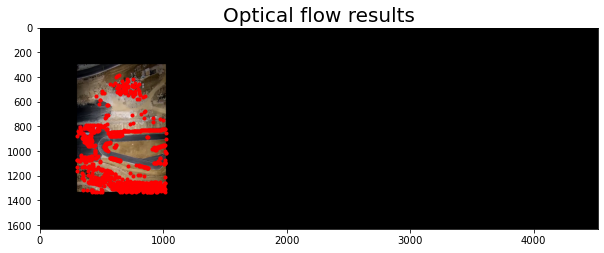

In [13]:

def opticalFLow(F0,F1,pts0):
    lk_params = dict( winSize  = (12,12), 
                  maxLevel = 7, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    F0_gray=cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
    F1_gray=cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
    pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)                   
    return (pts1,status)
pts1,status=opticalFLow(b_img1,b_img2,pts)
plt.imshow(img1toShow1)
plt.title("Optical flow results",fontsize=20)
plt.plot(pts[:,0,0], pts[:,0,1],'.r'); 
plt.savefig('second.png')

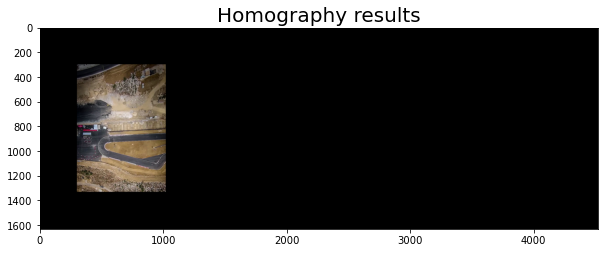

In [14]:
def find_homography(frame0,frame0_pts,lastframe,lastframe_pts):
    H, mask = cv2.findHomography(lastframe_pts,frame0_pts,cv2.RANSAC,5.0)
    h1,w1 = lastframe.shape[:2]
    warp = cv2.warpPerspective(lastframe, H, (w1,h1))
    pts_ref=cv2.perspectiveTransform(lastframe_pts,H)
    return (warp,pts_ref)
b_img1=addBorder(img1)
pts=getPoints(b_img1)
pts1,status=opticalFLow(b_img1,b_img2,pts)
pano,_=find_homography(b_img1,pts,b_img2,pts1)

plt.imshow(cv2.cvtColor(pano,cv2.COLOR_BGR2RGB))
plt.title("Homography results",fontsize=20);

In [15]:
cap = cv2.VideoCapture('P3_racing.mov')



# Take first frame and find corners in it
ret, F0 = cap.read()
F0=addBorder(F0)

h,w,_ = F0.shape
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX') # or just copy it from the original video
out = cv2.VideoWriter('racing_panorama.mp4',fourcc, FPS, (w,h)) # (W,H) should be integers

pts0 = getPoints(F0)
pts_ref = pts0.copy()
counter=0
pano=F0

while True:
    ret, F1 = cap.read() # read next frame
    if ret==True:
        F1=addBorder(F1)
        pts1,status=opticalFLow(F0,F1,pts0)
        
        
        # delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        pts_ref = pts_ref[status[:,0]==1]
        
        
        if (counter%25==0):
            # find homogrpahy and warp perspective
            H,_ = cv2.findHomography(pts1, pts_ref, cv2.RANSAC,5.0)
            F1_warp = cv2.warpPerspective(F1, H, (w,h))
            pts1=getPoints(F1)
            pts_ref=cv2.perspectiveTransform(pts1,H)
            pano  = np.maximum(F1_warp,pano)
            # visualize and save result 
            cv2.imshow('final',pano)
            out.write(pano)
        # update the previous frame and previous points
        F0=F1
        pts0 = pts1
        counter+=1
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break

cap.release() 
out.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);

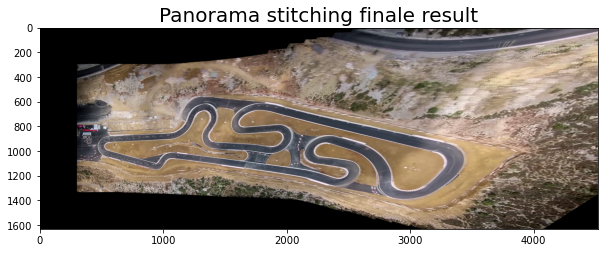

In [16]:
plt.imshow(cv2.cvtColor(pano,cv2.COLOR_BGR2RGB))
plt.title("Panorama stitching finale result",fontsize=20);
plt.savefig('5.png')

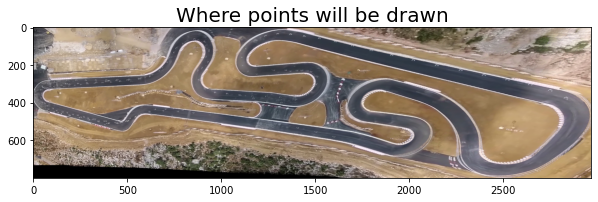

In [17]:
tst=pano[600:1400,470:3440]
plt.imshow(cv2.cvtColor(tst,cv2.COLOR_BGR2RGB))
plt.title("Where points will be drawn",fontsize=20);
plt.savefig('7.png')

In [19]:
pano2=pano.copy()

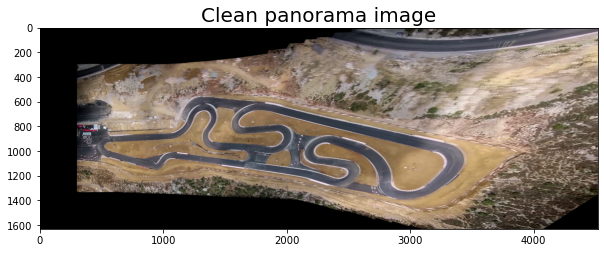

In [20]:
kernel = np.ones((5,5),np.uint8)
roi = pano2[600:1400,470:3440]
roi[:] =cv2.erode(roi,kernel)
roi[:]=cv2.dilate(roi,kernel)
plt.imshow(cv2.cvtColor(pano2,cv2.COLOR_BGR2RGB))
plt.title("Clean panorama image",fontsize=20);
plt.savefig('6.png')

## Update find homography function to return only the homography matrix 

In [21]:
def find_homography(frame0_pts,lastframe,lastframe_pts):
    H, mask = cv2.findHomography(lastframe_pts, frame0_pts,cv2.RANSAC,5.0)
    h1,w1 = lastframe.shape[:2]
    return (H)
b_img1=addBorder(img1)
b_img2=addBorder(img2)
pts=getPoints(b_img1)
pts1,s=opticalFLow(b_img1,b_img2,pts)
H=find_homography(pts,b_img2,pts1)

## Stabilizing video

In [22]:
cap = cv2.VideoCapture('P3_racing.mov')
h,w,_ = F0.shape
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX') 
out = cv2.VideoWriter('racing_stabilized1.mp4',fourcc, FPS, (w,h))
out2=cv2.VideoWriter('racing_stabilized_without_pano.mp4',fourcc, FPS, (w,h))

# Take first frame and find corners in it
ret, F0 = cap.read()
F0=addBorder(F0)
pts0 = getPoints(F0)
pts_ref = pts0.copy()
counter=0
h1=1030
w1=720
while True:
    ret, F1 = cap.read() # read next frame
    if ret==True:
        
        
        F1=addBorder(F1)
        # calculate optical flow
        pts1, status=opticalFLow(F0,F1,pts0)
        # delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        pts_ref = pts_ref[status[:,0]==1]
        # find homogrpahy and warp perspective
        H=find_homography(pts_ref,F1,pts1)
        F1_warp = cv2.warpPerspective(F1, H, (w,h))
        if (counter%25==0):
            pts1= getPoints(F1)
            pts_ref=cv2.perspectiveTransform(pts1,H)
        if (counter==500):
            pltFrame=F1_warp
        # update the previous frame and previous points
        F0 = F1
        pts0 = pts1
        final=np.maximum(pano2,F1_warp)
        # visualize and save result 
        cv2.imshow('final',final)
        out2.write(F1_warp)
        out.write(final)
        counter+=1
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break

cap.release() 
out.release()
out2.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);

## An example of warp frame

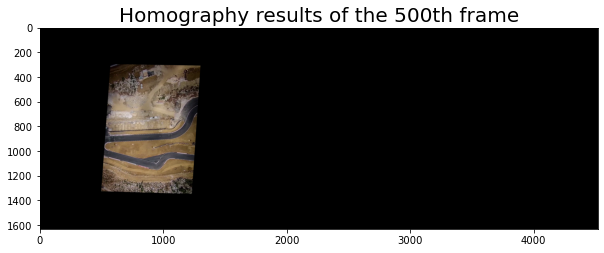

In [23]:
plt.imshow(cv2.cvtColor(pltFrame,cv2.COLOR_BGR2RGB));
plt.title("Homography results of the 500th frame",fontsize=20)
plt.savefig('4.png');

## Mask for racing track

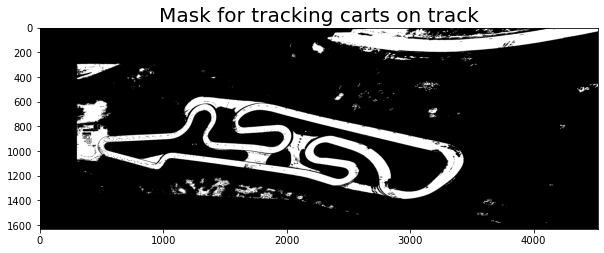

In [24]:
lower_blue = np.array([30,0,0])
upper_blue = np.array([170,100,130])
hsv=cv2.cvtColor(pano,cv2.COLOR_BGR2HSV)
pano_thresh = cv2.inRange(hsv, lower_blue, upper_blue)
plt.imshow(pano_thresh)
plt.title("Mask for tracking carts on track",fontsize=20)
plt.savefig('8.png');

# Tracking and plotting cart lines
Using goodfeaturestotrack with opticalflow to plot points.                                                
Plotting only points that on track by mask and only the points that "moves" enough.

In [26]:
cap = cv2.VideoCapture('racing_stabilized1.mp4')

# params for corner detection
feature_params = dict( maxCorners = 800,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 9 )

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take first frame and find corners in it
ret, F0 = cap.read()
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = None, **feature_params)

# colors:
n = pts0.size//2 
colors = np.random.randint(0,255,(n,3))
        
h,w=F0_gray.shape

FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('racing_stabilized_plot.mp4',fourcc, FPS, (w,h))

# Create a mask image for drawing purposes
canvas = np.zeros_like(F0)

counter = 0 # frames counter
while(1):
    ret,F1 = cap.read()
    
    if ret==True:
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)
        # delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        colors = colors[status[:,0]==1]
        tracking_mask = np.zeros_like(F1_gray) + 255
        for (p0,p1,clr) in zip(pts0,pts1,colors):
            x0,y0 = p0.squeeze().astype(np.int)
            x1,y1 = p1.squeeze().astype(np.int)
            # plotting points that moves enough and in masks
            if (np.sqrt(((x0-x1)**2)+((y0-y1)**2))>1.42): 
                if (x0>470 and x0<3440 and x1>470 and x1<3440 and y0>600 and y0<1400 and y1>600 and y1<1400):
                    if (pano_thresh[y0,x0]!=0 and pano_thresh[y1,x1]!=0):
                        canvas = cv2.line(canvas, (x0,y0),(x1,y1), clr.tolist(), 9) 
                        F1 = cv2.circle(F1,(x1,y1),10,clr.tolist(),-1) # new points
                        tracking_mask = cv2.circle(tracking_mask, (x1,y1),25,0,-1)
        
        # visualize the results
        canvas = np.uint8(canvas*0.92) # fade out canvas  
        final = cv2.add(F1, canvas)
        cv2.imshow('final',final)
        cv2.imshow('t',tracking_mask)
        out.write(final)
        counter += 1
        # find new features to track: 
        if (counter%25)==0: 
            new_pts = cv2.goodFeaturesToTrack(F1_gray, mask = tracking_mask, **feature_params)
            if new_pts is not None:
                n = new_pts.size//2
                new_colors = np.random.randint(0,255,(n,3))
                colors = np.vstack((colors,new_colors))
                pts1 = np.vstack((pts1,new_pts))
        if (counter==500):
            pltFrame2=final
          
        # update the previous frame and previous points
        F0_gray = F1_gray
        pts0 = pts1
         
            
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
            
    else: # no frames to read
        break

cv2.destroyAllWindows()
cap.release()
out.release()
cv2.waitKey(1)

-1

## An example of plotted lines

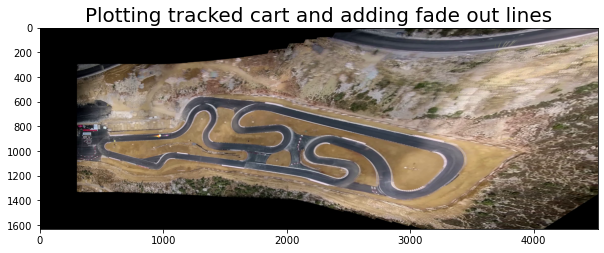

In [27]:
plt.imshow(cv2.cvtColor(pltFrame2,cv2.COLOR_BGR2RGB));
plt.title('Plotting tracked cart and adding fade out lines',fontsize=20)
plt.savefig('9.png');

## Adding borders to shown frame

In [29]:
cap = cv2.VideoCapture('P3_racing.mov')
cap2=cv2.VideoCapture('racing_stabilized_plot.mp4')
# Take first frame and find corners in it
ret, F0 = cap.read()
F0=addBorder(F0)
h,w,_ = F0.shape
FPS = cap2.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX') # or just copy it from the original video
out = cv2.VideoWriter('racing_stabilized_with_plot_frame1.mp4',fourcc, FPS, (w,h)) # (W,H) should be integers
pts0 = getPoints(F0)
pts_ref = pts0.copy()
counter=0
h1=1030
w1=720
N=300
while True:
    ret, F1 = cap.read() # read next frame
    r,pano_F=cap2.read()
    if ret==True and r==True:
        
        
        F1=addBorder(F1)
        # calculate optical flow
        pts1, status=opticalFLow(F0,F1,pts0)
        # delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        
        pts_ref = pts_ref[status[:,0]==1]
        pts = np.float32([ [N,N],[N,N+h1],[N+w1,N+h1],[N+w1,N] ]).reshape(-1,1,2)
        #img1_marks = cv2.polylines(F1.copy(),[pts],True,(255,0,0),5, cv2.LINE_AA)
        
        # find homogrpahy and warp perspective
        H=find_homography(pts_ref,F1,pts1)
        pts_plt=cv2.perspectiveTransform(pts,H)
        img1_marks = cv2.polylines(pano_F,np.int32([pts_plt]),True,(0,0,255),8, cv2.LINE_AA)
        if (counter%25==0):
            pts1= getPoints(F1)
            pts_ref=cv2.perspectiveTransform(pts1,H)
        if (counter==500):
            pltFrame3=img1_marks
        # update the previous frame and previous points
        F0 = F1
        pts0 = pts1
        # save result 
        out.write(img1_marks)
        counter+=1
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break

cap.release() 
out.release()
out2.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);

## An example of frame with borders

(1630, 4520, 3)


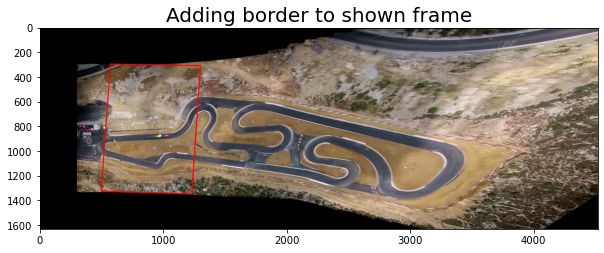

In [30]:
plt.imshow(cv2.cvtColor(pltFrame3,cv2.COLOR_BGR2RGB));
plt.title("Adding border to shown frame",fontsize=20)
plt.savefig('11.png');
print(pltFrame3.shape)

## Finale results with original video and output video together

In [31]:
cap = cv2.VideoCapture('P3_racing.mov')
cap2=cv2.VideoCapture('racing_stabilized_with_plot_frame1.mp4')
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# finale video size:
h=2335
w=2280
counter=0
out = cv2.VideoWriter('finale_vid.mp4',fourcc, FPS, (w,h))
font_params = dict(org = (250,1350),
                   fontFace = cv2.FONT_HERSHEY_COMPLEX,
                   fontScale = 3,
                   thickness=9,
                   color = (255,255,255),
                   lineType = 1)  
font_params2 = dict(org = (750,150),
                   fontFace = cv2.FONT_HERSHEY_COMPLEX,
                   fontScale =3,
                   thickness=9,
                   color = (255,255,255),
                   lineType = 1)  
while True:
    ret, F1 = cap.read() # read next frame
    r,pano_F=cap2.read()
    
    if ret==True and r==True:
        pano_F=cv2.resize(pano_F,(2280,815))
        F1=cv2.resize(F1,(1480,920))
        
        #adding border to original frame after resizing it
        res = cv2.copyMakeBorder(F1.copy(), 250,350, 400,400, cv2.BORDER_CONSTANT)
        cv2.putText(res,'Original video', **font_params2)
        cv2.putText(res,'Plotting and tracking carts video', **font_params)
        final = np.concatenate((res, pano_F), axis = 0)
        cv2.imshow('final',final)
        out.write(final)
        if (counter==500):
            pltFrame4=final.copy()
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
        counter+=1
    else:
        break
cap.release() 
out.release()
cap2.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);

## An example of finale video frame:

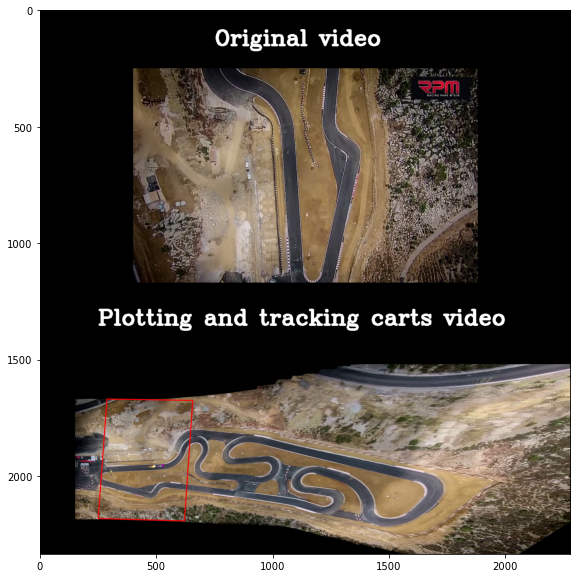

In [32]:
plt.imshow(cv2.cvtColor(pltFrame4,cv2.COLOR_BGR2RGB));
plt.savefig('12.png');